# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [2]:
!pip install datasets -q


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List, Union, Optional
import string

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [6]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [7]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1

print(f'Число слов после токенизации текста: {len(words)}')

  0%|          | 0/120000 [00:00<?, ?it/s]

Число слов после токенизации текста: 102166


In [8]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

Размер словаря: 11842


In [9]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [10]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [11]:
print('Батч тренировочных данных:', next(iter(train_dataloader)), sep = '\n', end = '\n')
print()
print('Батч валидационных данных:', next(iter(eval_dataloader)), sep = '\n')

Батч тренировочных данных:
{'input_ids': tensor([[ 4900,  2480,  2309,  ...,  4376,  4376,  4376],
        [ 4900,   336,  8673,  ...,  4376,  4376,  4376],
        [ 4900,  1710,  5990,  ...,  4376,  4376,  4376],
        ...,
        [ 4900, 10938, 11403,  ...,  4376,  4376,  4376],
        [ 4900,  9475,  5132,  ...,  4376,  4376,  4376],
        [ 4900,  5147,  7539,  ..., 11837, 11059,    25]], device='cuda:0'), 'label': tensor([0, 3, 0, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 3, 0, 0, 0, 3, 3, 3, 1, 3, 0, 3,
        2, 2, 2, 1, 2, 0, 0, 3], device='cuda:0')}

Батч валидационных данных:
{'input_ids': tensor([[ 4900, 10272,  1122,  ...,  4376,  4376,  4376],
        [ 4900,  8210, 11646,  ...,  4376,  4376,  4376],
        [ 4900,  7918,  4050,  ...,  4376,  4376,  4376],
        ...,
        [ 4900,  8290,  6698,  ...,  4376,  4376,  4376],
        [ 4900, 10272,  3223,  ...,  4376,  4376,  4376],
        [ 4900,  5267,  3410,  ...,  4376,  4376,  4376]], device='cuda:0'), 'label': tensor([

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [12]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

#### Базовая модель

In [13]:
# Реализация базовой модели RNN

class BaseRNN(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, padding_idx: Optional[int] = None, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, hidden_dim, padding_idx)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first = True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
    
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding_layer(input_batch)  # [batch_size, seq_len, hidden_dim] - размер входных данных
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim] - скрытое состояние не обрабатывается

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [14]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = BaseRNN(
        hidden_dim=256, vocab_size=len(vocab), padding_idx = word2ind.get('<pad>'), 
        aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc
    print(f"Лучшая accuracy для подхода {aggregation_type}: {(max(acc_type[aggregation_type]) * 100):.2f}")

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 90.32
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода mean: 91.06


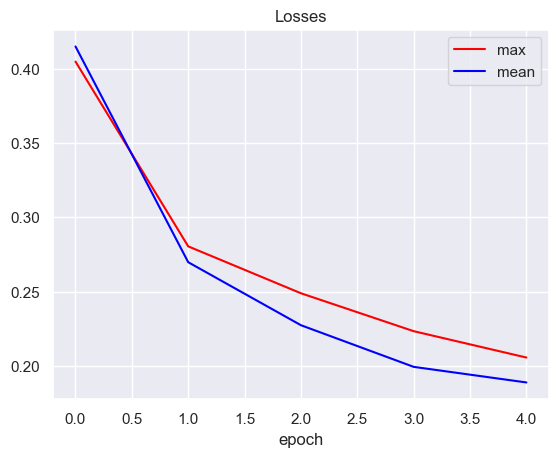

In [15]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.32
Лучшая accuracy для подхода mean: 91.06


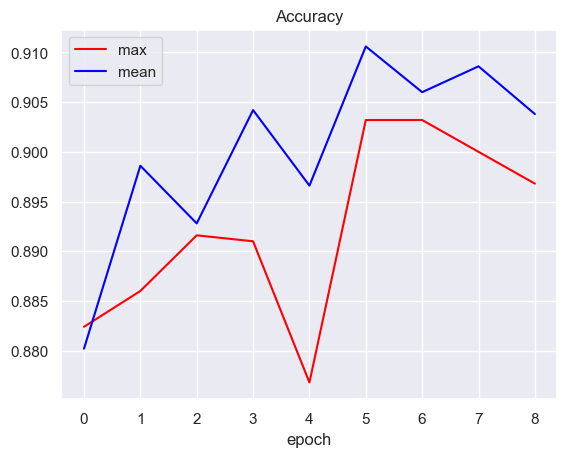

In [16]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

*Вывод:* Использование версии *RNN* с семинара позволило добиться целевой метрики `accuracy` равной 90.96 с учётом агрегации данных по **среднему**. По графикам изменения `Loss`, `Accuracy` можно наблюдать, что снижение величины функции потерь при небольшом итераций сопровождается нестабильным ростом целевой метрики `accuracy`, что может указывать на проблемы с обновлением весов из-за необходимости расчёта градиентов по всей входной последовательности.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

#### Экспериментальная модель №1

В представленной базовой версии алгоритма предложена операция пулинга `self.aggregation` после обработки последовательности рекуррентным слоем, т.е. экстракция информации, путём применения агрегаций типа: `max`, `mean`, чтобы агрегировать информацию со всех компонент каждого из векторов отдельных последовательностей.

В эксперименте №1 предлагается использовать процесс конкатенации векторов скрытого состояния `h_t`, соответствующих каждому из последних элементов каждой последовательности батча, и векторов, полученных путём использования операции пулинга для каждого элемента батча. Для обеспечения работы нейросети с *расширенными векторами*, предполагается использовать дополнительный слой `self.linear_ext`, для обеспечения его работы предусматривается увеличение количества его входных нейронов: `2 * hidden_dim`.

In [17]:
# Реализация первой экспериментальной модели RNN

class ResRNN(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, padding_idx: Optional[int] = None, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, hidden_dim, padding_idx)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers = 1, batch_first = True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_ext = nn.Linear(2 * hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding_layer(input_batch)  # [batch_size, seq_len, hidden_dim] - размер входных данных
        output, h_t = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim], [batch_size, hidden_dim] 
        
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear_ext(self.non_lin(torch.cat((output, h_t[0]), dim = 1)))) # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [18]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}
base_models_res = {}

resulting_accuracy = 0

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_res = ResRNN(
        hidden_dim=256, vocab_size=len(vocab), padding_idx = word2ind.get('<pad>'), 
        aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_res.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_res.train()
        
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_res(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_res.eval()
                resulting_accuracy = evaluate(model_res, eval_dataloader)
                acc.append(resulting_accuracy)
                if resulting_accuracy >= max(acc):
                    base_models_res[aggregation_type] = model_res.state_dict() 
                model_res.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc
    print(f"Лучшая accuracy для подхода {aggregation_type}: {(max(acc_type[aggregation_type]) * 100):.3f}")

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 90.840
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода mean: 90.620


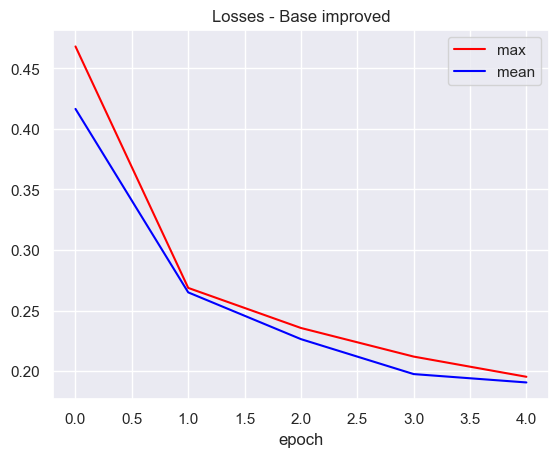

In [19]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses - Base improved')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.84
Лучшая accuracy для подхода mean: 90.62


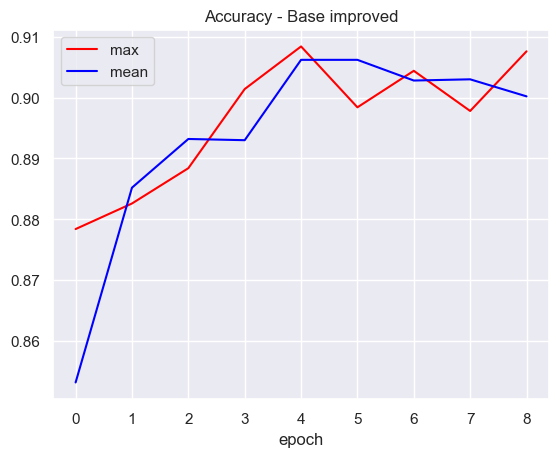

In [20]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy - Base improved')
plt.xlabel("epoch")
plt.legend()
plt.show()

*Вывод:* использование конкатенации агрегированных эмбеддингов и векторов скрытого состояния позволило увеличить качество прогнозирования в случаях использования пулинга типа `max`, в случаях агрегации путём использования агргегации типа `mean` получилось стабилизировать изменение ключевой метрики `accuracy` на большем числе эпох.

#### Экспериментальная модель №2

Улучшение качества прогнозирования возможно за счёт использования более сложных архитектур типа: `LSTM`, `GRU`. В рамках третьей модели предполагается *использование* рекуррентного слоя типа `GRU`, архитектура исходной модели после рекурретного слоя сохранена. Векторы "краткосрочной" и долгосрочной памяти после рекуррентного слоя не используются.

In [21]:
# Реализация второй экспериментальной модели RNN

class GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, padding_idx: Optional[int] = None, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, hidden_dim, padding_idx)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first = True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding_layer(input_batch)  # [batch_size, seq_len, hidden_dim] - размер входных данных
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim], [batch_size, hidden_dim] 
        
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output))) # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [22]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}
base_models_gru = {}

resulting_accuracy = 0

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_gru = GRU(
        hidden_dim=256, vocab_size=len(vocab), padding_idx = word2ind.get('<pad>'), 
        aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_gru.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_gru.train()
        
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_gru(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_gru.eval()
                resulting_accuracy = evaluate(model_gru, eval_dataloader)
                acc.append(resulting_accuracy)
                if resulting_accuracy >= max(acc):
                    base_models_gru[aggregation_type] = model_gru.state_dict()             
                model_gru.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc
    print(f"Лучшая accuracy для подхода {aggregation_type}: {(max(acc_type[aggregation_type]) * 100):.3f}")

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 91.840
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода mean: 91.680


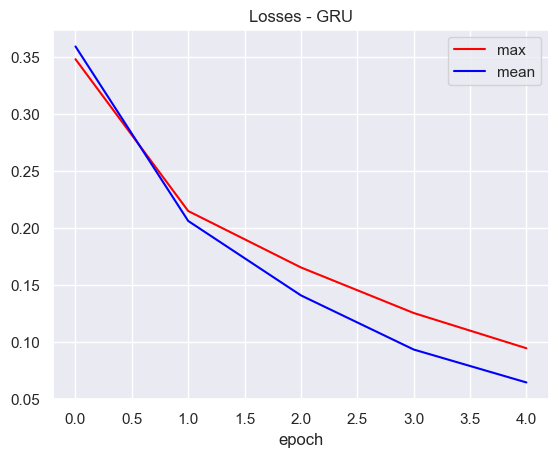

In [23]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses - GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.84
Лучшая accuracy для подхода mean: 91.68


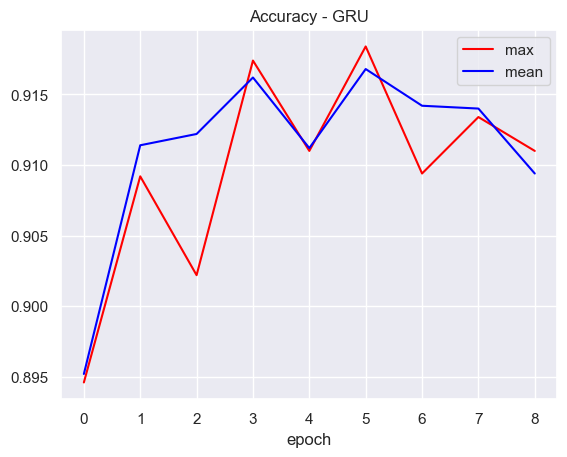

In [24]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy - GRU')
plt.xlabel("epoch")
plt.legend()
plt.show()

*Вывод:* использование слоёв типа `GRU` позволило получить прирост в качестве прогнозной модели на обоих типах агрегаций. Однако итоговое качество модели не было достаточно стабильным, к концу последней эпохи обучения можно также наблюдать, что целевая метрика на валидационной выборке стала ухудшаться. 

#### Экспериментальная модель №3

Улучшение качества прогнозирования возможно за счёт использования более сложных архитектур типа: `LSTM`, `GRU`. В рамках третьей модели предполагается *использование* рекуррентного слоя типа `LSTM`, архитектура исходной модели после рекурретного слоя сохранена. Векторы "краткосрочной" и долгосрочной памяти после рекуррентного слоя не используются.

In [25]:
# Реализация второй экспериментальной модели RNN

class LSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, padding_idx: Optional[int] = None, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, hidden_dim, padding_idx)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first = True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding_layer(input_batch)  # [batch_size, seq_len, hidden_dim] - размер входных данных
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim], [batch_size, hidden_dim] 
        
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output))) # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [26]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}
base_models_lstm = {}

resulting_accuracy = 0

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model_lstm = LSTM(
        hidden_dim=256, vocab_size=len(vocab), padding_idx = word2ind.get('<pad>'), 
        aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model_lstm.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model_lstm.train()
        
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model_lstm(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model_lstm.eval()
                resulting_accuracy = evaluate(model_lstm, eval_dataloader)
                acc.append(resulting_accuracy)
                if resulting_accuracy >= max(acc):
                    base_models_lstm[aggregation_type] = model_lstm.state_dict()             
                model_lstm.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
    
    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc
    print(f"Лучшая accuracy для подхода {aggregation_type}: {(max(acc_type[aggregation_type]) * 100):.3f}")

Starting training for max


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 91.160
Starting training for mean


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Лучшая accuracy для подхода mean: 91.820


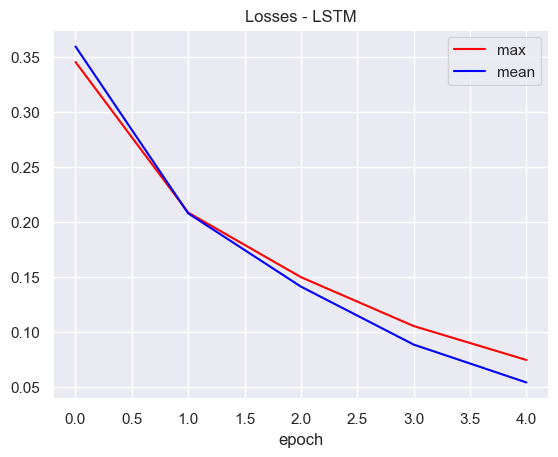

In [27]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses - LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.16
Лучшая accuracy для подхода mean: 91.82


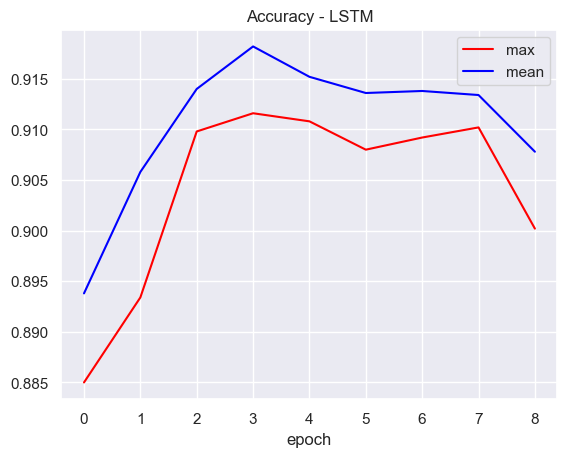

In [28]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy - LSTM')
plt.xlabel("epoch")
plt.legend()
plt.show()

*Вывод:* использование слоёв типа `LSTM` позволило получить прирост в качестве прогнозной модели на обоих типах агрегаций, однако стабилизировать качество не удалось. По сравнению с использованием `GRU` слоя целевая метрика не претерпевала значительных скачкоообразных изменений на обоих типах агрегаций.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

#### Лучшая модель

На основании проведённых ранее экспериментов было выявлено, что наилучшее качество наблюдалось для модели, использующей рекуррентный слой типа `GRU`, в качестве функции агрегации использовался `MaxPooling`. Расчёт качества приедён ниже.

In [51]:
best_model = GRU(
        hidden_dim=256, vocab_size=len(vocab), padding_idx = word2ind.get('<pad>'), 
        aggregation_type='max').to(device)

best_model.load_state_dict(base_models_gru['max'])

<All keys matched successfully>

In [87]:
print('Качество лучшей модели GRU (accuracy):', evaluate(best_model, eval_dataloader))

Качество лучшей модели GRU (accuracy): 0.9161999821662903


### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

#### Обработка экспериментальных данных

В рамках работы над задачей по классификации текста с помощью рекуррентных нейросетей были проведены несколько экспериментов с моделями нейросетей. Основной целью эксперимента было определение влияния архитектурных решений на итоговое качество прогнозной модели. Были проведены **3** эксперимента:

1. Модифицированная базовая модель: в базовой модели результаты операции пулинга конкатенировались с вектором скрытого состояния, полученным после обработки последнего элемента последовательности. Архитектурное решение позволило увеличить качество прогнозной модели на 0.01 ед., однако в данной модели так же как и в базовой модели наблюдались колебания качества на протяжении всех эпох обучения, что могло быть связано со значительными изменениями градиентов при обучении.
2. Модель, использующая рекуррентный слой типа `GRU`. Использование нового типа слоя позволило улучшить качество прогнозной модели, увеличить его до 0.91, однако в данной модели также можно было наблюдать значительные колебания качества при обучении, причём с увеличением числа эпох качество прогнозной модели ухудшалось. Модель даного типа, использующая операцию `MaxPooling` была выбрана в качестве оптимальной.
3. Модель, использующая рекуррентный слой типа `LSTM`. Применение более сложной архитектуры рекуррентного слоя, как и в эксперименте с `GRU`, позволило добиться улучшения качества прогнозов. При этом анализ графиков основных метрик показывает, что модели данного типа меньше подвержены проблемам со сходимостью, так как значительных колебаний целевой метрики на протяжении всего периода обучения не наблбюдалось. 

Стоит отметить, что использование операций пулинга типа `AvgPool` (агрегации типа `mean`) зачастую приводит к получению более стабильных результатов в процессе обучения по отношению к операциям типа `MaxPool`, что наблюдается на всех графиках экспериментальных моделей.

*Оптимальная модель:* в качестве оптимальной модели была выбрана модель с рекуррентным слоем типа `GRU` (используемая в модели агрегация - `MaxPooling`). Прогнозирование с помощью функции `evaluate` даёт целевую метрику `accuracy`, равную **0.916**. Параметры модели представлены ниже:

```
GRU(
  (embedding_layer): Embedding(11842, 256, padding_idx=4376)
  (gru): GRU(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=4, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)
```

Модели типа `GRU` обладают меньшим числом параметров по сравнению с моделями типа `LSTM`, однако более устойчивы по отношению к базовым моделям рекуррентных слоёв. В данной задаче модель оптимальна, так как по качеству приближена к более сложной модели `LSTM` (обладая меньшим числом параметров), однако лучше справляется с обработкой последователбностей по отношению к типовым моделям `RNN`.